In [1]:
%load_ext autoreload

In [3]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import mintpy
from osgeo import gdal
from mintpy.utils import plot as pp
from mintpy.utils import readfile, utils as ut 
import h5py
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mintpy import view
from mintpy.objects import timeseries
from operator import itemgetter 
import datetime
from datetime import timedelta
from scipy import interpolate
import matplotlib.dates as mdates

from miaplpy.objects.invert_pixel import process_pixel 
from scipy import stats
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
font = {'family' : 'DejaVu Sans',
        'size'   : 15}

In [4]:
project_dir = './Miami_data_Sentinel'
if not os.path.exists(project_dir):
    !wget https://zenodo.org/record/7311811/files/Miami_data_Sentinel.tar.xz
    !tar -xvJf Miami_data_Sentinel.tar.xz
    
out_dir = './out_figures'
#os.chdir(project_dir)

geom_dsm = project_dir + '/dsm_reprojected_wgs84.tif'

out_amplitude = project_dir + '/mean_amplitude.npy'

plt.rcParams["font.size"] = "20"


In [5]:
def get_data_scatter(box, ps, offsetx=0, offsety=0):
    lats = [float(i) for i in box[0].split(':')]
    lons = [float(i) for i in box[1].split(':')]
    
    demError_file = project_dir + '/demErr.h5'
    demError_file_std = project_dir + '/demErr_std.h5'
    geo_file = project_dir + '/geo_corr/geometryRadar.h5'
    
    datas, atrs = readfile.read(geom_dsm)
    coords = ut.coordinate(atrs) 


    mask_file_t = project_dir + '/maskTempCoh.h5'
    mask_file_ps = project_dir + '/maskPS.h5'
    mask_file_w = project_dir + '/waterMask.h5'

    
    mask_w = readfile.read(mask_file_w, datasetName='mask')[0]
    mask_t = readfile.read(mask_file_t, datasetName='mask')[0]*mask_w
    mask_p = readfile.read(mask_file_ps, datasetName='mask')[0]*mask_w
    #
    
    if ps:
        mask = mask_p
    else:
        mask=mask_t

    latitude = readfile.read(geo_file, datasetName='latitude')[0]
    longitude = readfile.read(geo_file, datasetName='longitude')[0]
    DEM = readfile.read(geo_file, datasetName='height')[0]+26

    demError = readfile.read(demError_file, datasetName='dem')[0] #+ DEM
    demError_STD = readfile.read(demError_file_std, datasetName='dem')[0] #+ DEM
    
    mask[latitude<lats[0]] = 0
    mask[latitude>lats[1]] = 0
    mask[longitude<lons[0]] = 0
    mask[longitude>lons[1]] = 0
    rr, cc = np.where(mask==1)
    cc += offsetx
    rr += offsety
    lat = np.array(latitude[mask==1])
    lon = np.array(longitude[mask==1])
    demerr = np.array(demError[mask==1])
    demerr_std = np.array(demError_STD[mask==1])
    dem = np.array(DEM[mask==1])
    dsm = np.empty(lat.shape)
    t = 0
    for i, j in zip(lat,lon):
        y,x = coords.geo2radar(i, j)[0:2]
        dsm[t] = datas[y, x] 
        t+=1
  
    return lon, lat, demerr, dsm, dem, demerr_std

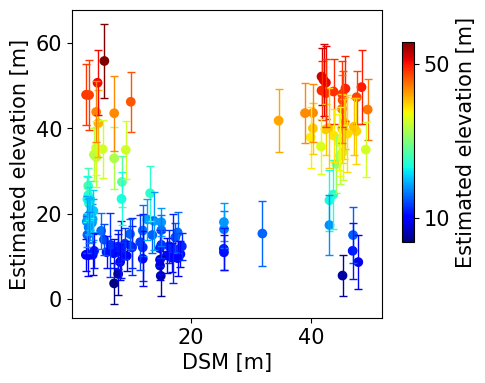

In [110]:
box = ['25.876:25.879','-80.1224:-80.120']
plt.rcParams["font.size"] = "15"



fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax=axs
lon, lat, demerr, dsm, dem, demerr_std = get_data_scatter(box=box, ps=True, offsetx=0, offsety=0)

im = ax.scatter(dsm, dem-demerr, c=dem-demerr, cmap='jet')


norm = matplotlib.colors.Normalize(vmin=min(dem-demerr), vmax=max(dem-demerr), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='jet')
time_color = np.array([(mapper.to_rgba(v)) for v in dem-demerr])

#loop over each data point to plot
for x, y, e, color in zip(dsm, dem-demerr,demerr_std, time_color):
    ax.errorbar(x, y, e, lw=1, capsize=3, color=color)



ax.set_xlabel('DSM [m]')
ax.set_ylabel('Estimated elevation [m]')

#ax.set_ylim(-5,65)
#ax.set_xlim(-5,65)
#cbar_ax1 = fig.add_axes([0.3, -0.1, 0.5, 0.03])
#fig.colorbar(im, cax=cbar_ax1,ticks=[0, 50], label='Estimated elevation [m]', orientation='horizontal')

cbar_ax1 = fig.add_axes([0.95, 0.3, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax1,ticks=[10, 50], label='Estimated elevation [m]', orientation='vertical')


correlation_matrix = np.corrcoef(dsm, -demerr)

#ax.set_title('R = {:.0f}%'.format(correlation_matrix[0,1]*100))

#plt.savefig(out_dir + '/1_hotel_correlation_demErr_ps.png', bbox_inches='tight', dpi=300)
plt.savefig(out_dir + '/2_hotel_correlation_demErr_ps.png', bbox_inches='tight', dpi=300)

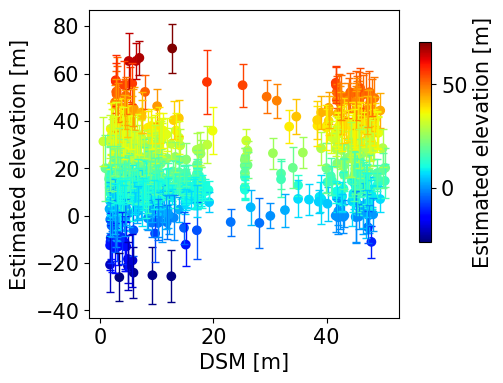

In [34]:
box = ['25.876:25.879','-80.1224:-80.120']
plt.rcParams["font.size"] = "15"



fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax=axs
lon, lat, demerr, dsm, dem, demerr_std = get_data_scatter(box=box, ps=False, offsetx=0, offsety=0)

im = ax.scatter(dsm, dem-demerr, c=dem-demerr, cmap='jet')


norm = matplotlib.colors.Normalize(vmin=min(dem-demerr), vmax=max(dem-demerr), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='jet')
time_color = np.array([(mapper.to_rgba(v)) for v in dem-demerr])

#loop over each data point to plot
for x, y, e, color in zip(dsm, dem-demerr,demerr_std, time_color):
    ax.errorbar(x, y, e, lw=1, capsize=3, color=color)



ax.set_xlabel('DSM [m]')
ax.set_ylabel('Estimated elevation [m]')

#ax.set_ylim(-40,85)
#ax.set_xlim(-40,85)
#cbar_ax1 = fig.add_axes([0.3, -0.1, 0.5, 0.03])
#fig.colorbar(im, cax=cbar_ax1,ticks=[0, 50], label='Estimated elevation [m]', orientation='horizontal')

cbar_ax1 = fig.add_axes([0.95, 0.3, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax1,ticks=[0, 50], label='Estimated elevation [m]', orientation='vertical')


correlation_matrix = np.corrcoef(dsm, -demerr)

#ax.set_title('R = {:.0f}%'.format(correlation_matrix[0,1]*100))


plt.savefig(out_dir + '/2_hotel_correlation_demErr_ds.png', bbox_inches='tight', dpi=300)

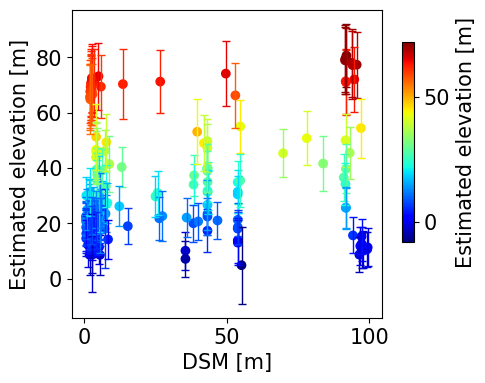

In [35]:
box = ['25.8936:25.8965','-80.1247:-80.1217']
plt.rcParams["font.size"] = "15"


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax=axs
lon, lat, demerr, dsm, dem, demerr_std = get_data_scatter(box=box, ps=True, offsetx=0, offsety=0)
im = ax.scatter(dsm, dem-demerr, c=-demerr, cmap='jet')
ax.set_xlabel('DSM [m]')
ax.set_ylabel('Estimated elevation [m]')

norm = matplotlib.colors.Normalize(vmin=min(dem-demerr), vmax=max(dem-demerr), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='jet')
time_color = np.array([(mapper.to_rgba(v)) for v in dem-demerr])

#loop over each data point to plot
for x, y, e, color in zip(dsm, dem-demerr,demerr_std, time_color):
    ax.errorbar(x, y, e, lw=1, capsize=3, color=color)



#ax.set_ylim(-40,110)
#ax.set_xlim(-40,110)
cbar_ax1 = fig.add_axes([0.95, 0.3, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax1,ticks=[0, 50], label='Estimated elevation [m]', orientation='vertical')

correlation_matrix = np.corrcoef(dsm, -demerr)


#ax.set_title('R = {:.0f}%'.format(correlation_matrix[0,1]*100))


plt.savefig(out_dir + '/2_oceana_correlation_demErr_ps.png',bbox_inches='tight', dpi=300)

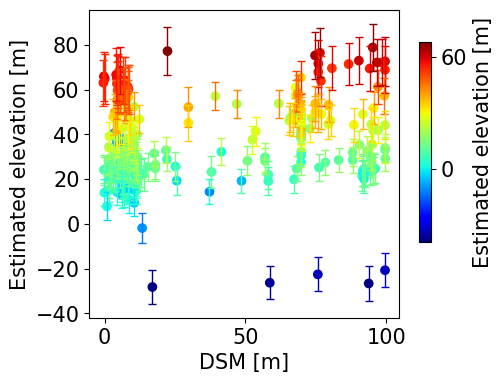

In [37]:
box = ['25.8871:25.8900','-80.1241:-80.1215']
plt.rcParams["font.size"] = "15"


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax=axs
lon, lat, demerr, dsm, dem, demerr_std = get_data_scatter(box=box, ps=True, offsetx=0, offsety=0)
im = ax.scatter(dsm, dem-demerr, c=-demerr, cmap='jet')
ax.set_xlabel('DSM [m]')
ax.set_ylabel('Estimated elevation [m]')

norm = matplotlib.colors.Normalize(vmin=min(dem-demerr), vmax=max(dem-demerr), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='jet')
time_color = np.array([(mapper.to_rgba(v)) for v in dem-demerr])

#loop over each data point to plot
for x, y, e, color in zip(dsm, dem-demerr,demerr_std, time_color):
    ax.errorbar(x, y, e, lw=1, capsize=3, color=color)



#ax.set_ylim(-40,110)
#ax.set_xlim(-40,110)
#cbar_ax1 = fig.add_axes([0.3, -0.1, 0.5, 0.03])
#fig.colorbar(im, cax=cbar_ax1,ticks=[0, 50], label='Estimated elevation [m]', orientation='horizontal')

cbar_ax1 = fig.add_axes([0.95, 0.3, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax1,ticks=[0, 60], label='Estimated elevation [m]', orientation='vertical')


correlation_matrix = np.corrcoef(dsm, -demerr)

#ax.set_title('R = {:.0f}%'.format(correlation_matrix[0,1]*100))



plt.savefig(out_dir + '/2_rregis_correlation_demErr_ps.png',bbox_inches='tight', dpi=300)

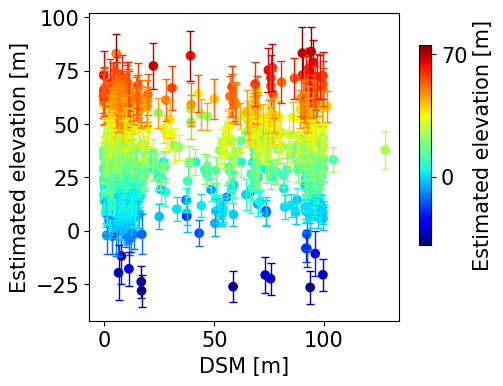

In [38]:
box = ['25.8871:25.8900','-80.1241:-80.1215']
plt.rcParams["font.size"] = "15"


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax=axs
lon, lat, demerr, dsm, dem, demerr_std = get_data_scatter(box=box, ps=False, offsetx=0, offsety=0)
im = ax.scatter(dsm, dem-demerr, c=-demerr, cmap='jet')
ax.set_xlabel('DSM [m]')
ax.set_ylabel('Estimated elevation [m]')

norm = matplotlib.colors.Normalize(vmin=min(dem-demerr), vmax=max(dem-demerr), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='jet')
time_color = np.array([(mapper.to_rgba(v)) for v in dem-demerr])

#loop over each data point to plot
for x, y, e, color in zip(dsm, dem-demerr,demerr_std, time_color):
    ax.errorbar(x, y, e, lw=1, capsize=3, color=color)



#ax.set_ylim(-40,110)
#ax.set_xlim(-40,110)
#cbar_ax1 = fig.add_axes([0.3, -0.1, 0.5, 0.03])
#fig.colorbar(im, cax=cbar_ax1,ticks=[0, 50], label='Estimated elevation [m]', orientation='horizontal')

cbar_ax1 = fig.add_axes([0.95, 0.3, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax1,ticks=[0, 70], label='Estimated elevation [m]', orientation='vertical')


correlation_matrix = np.corrcoef(dsm, -demerr)

#ax.set_title('R = {:.0f}%'.format(correlation_matrix[0,1]*100))



plt.savefig(out_dir + '/2_rregis_correlation_demErr_ds.png',bbox_inches='tight', dpi=300)

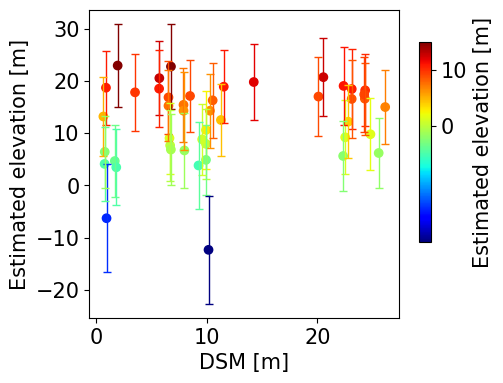

In [39]:
box = ['25.8895:25.8904','-80.1342:-80.1331']
plt.rcParams["font.size"] = "15"


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax=axs
lon, lat, demerr, dsm, dem, demerr_std = get_data_scatter(box=box, ps=True, offsetx=0, offsety=0)
im = ax.scatter(dsm, dem-demerr, c=-demerr, cmap='jet')
ax.set_xlabel('DSM [m]')
ax.set_ylabel('Estimated elevation [m]')

norm = matplotlib.colors.Normalize(vmin=min(dem-demerr), vmax=max(dem-demerr), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='jet')
time_color = np.array([(mapper.to_rgba(v)) for v in dem-demerr])

#loop over each data point to plot
for x, y, e, color in zip(dsm, dem-demerr,demerr_std, time_color):
    ax.errorbar(x, y, e, lw=1, capsize=3, color=color)



#ax.set_ylim(-30,50)
#ax.set_xlim(-30,50)

#cbar_ax1 = fig.add_axes([0.3, -0.1, 0.5, 0.03])
#fig.colorbar(im, cax=cbar_ax1,ticks=[0, 50], label='Estimated elevation [m]', orientation='horizontal')

cbar_ax1 = fig.add_axes([0.95, 0.3, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax1,ticks=[0, 10], label='Estimated elevation [m]', orientation='vertical')

correlation_matrix = np.corrcoef(dsm, -demerr)

#ax.set_title('R = {:.0f}%'.format(correlation_matrix[0,1]*100))



plt.savefig(out_dir + '/2_kai_correlation_demErr_ps.png',bbox_inches='tight', dpi=300)

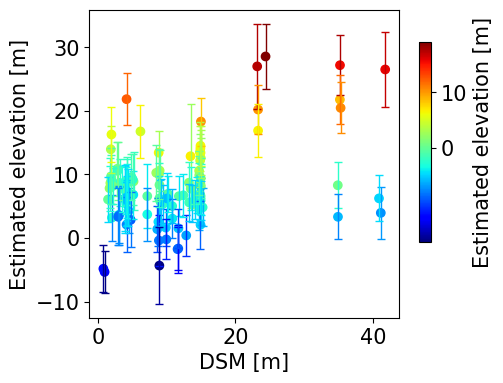

In [40]:
box = ['25.8796:25.8810','-80.1231:-80.1208']
plt.rcParams["font.size"] = "15"


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax=axs
lon, lat, demerr, dsm, dem, demerr_std = get_data_scatter(box=box, ps=True, offsetx=0, offsety=0)
im = ax.scatter(dsm, dem-demerr, c=-demerr, cmap='jet')
ax.set_xlabel('DSM [m]')
ax.set_ylabel('Estimated elevation [m]')

norm = matplotlib.colors.Normalize(vmin=min(dem-demerr), vmax=max(dem-demerr), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='jet')
time_color = np.array([(mapper.to_rgba(v)) for v in dem-demerr])

#loop over each data point to plot
for x, y, e, color in zip(dsm, dem-demerr,demerr_std, time_color):
    ax.errorbar(x, y, e, lw=1, capsize=3, color=color)



#ax.set_ylim(-30,50)
#ax.set_xlim(-30,50)

#cbar_ax1 = fig.add_axes([0.3, -0.1, 0.5, 0.03])
#fig.colorbar(im, cax=cbar_ax1,ticks=[0, 50], label='Estimated elevation [m]', orientation='horizontal')

cbar_ax1 = fig.add_axes([0.95, 0.3, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax1,ticks=[0, 10], label='Estimated elevation [m]', orientation='vertical')

correlation_matrix = np.corrcoef(dsm, -demerr)

#ax.set_title('R = {:.0f}%'.format(correlation_matrix[0,1]*100))



plt.savefig(out_dir + '/2_residence_correlation_demErr_ps.png',bbox_inches='tight', dpi=300)

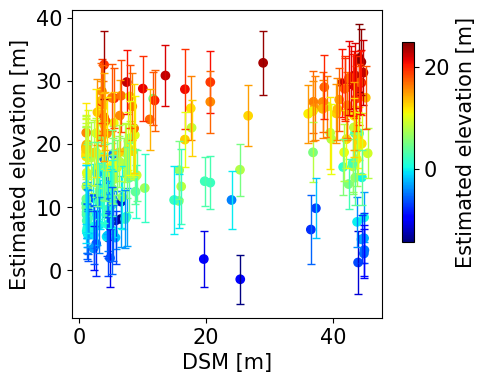

In [41]:
box = ['25.8822:25.8847','-80.1236:-80.1210']
plt.rcParams["font.size"] = "15"


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax=axs
lon, lat, demerr, dsm, dem, demerr_std = get_data_scatter(box=box, ps=True, offsetx=0, offsety=0)
im = ax.scatter(dsm, dem-demerr, c=-demerr, cmap='jet')
ax.set_xlabel('DSM [m]')
ax.set_ylabel('Estimated elevation [m]')

norm = matplotlib.colors.Normalize(vmin=min(dem-demerr), vmax=max(dem-demerr), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='jet')
time_color = np.array([(mapper.to_rgba(v)) for v in dem-demerr])

#loop over each data point to plot
for x, y, e, color in zip(dsm, dem-demerr,demerr_std, time_color):
    ax.errorbar(x, y, e, lw=1, capsize=3, color=color)



#ax.set_ylim(-30,50)
#ax.set_xlim(-30,50)

#cbar_ax1 = fig.add_axes([0.3, -0.1, 0.5, 0.03])
#fig.colorbar(im, cax=cbar_ax1,ticks=[0, 50], label='Estimated elevation [m]', orientation='horizontal')

cbar_ax1 = fig.add_axes([0.95, 0.3, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax1,ticks=[0, 20], label='Estimated elevation [m]', orientation='vertical')

correlation_matrix = np.corrcoef(dsm, -demerr)

#ax.set_title('R = {:.0f}%'.format(correlation_matrix[0,1]*100))



plt.savefig(out_dir + '/2_grandbeach_correlation_demErr_ps.png',bbox_inches='tight', dpi=300)

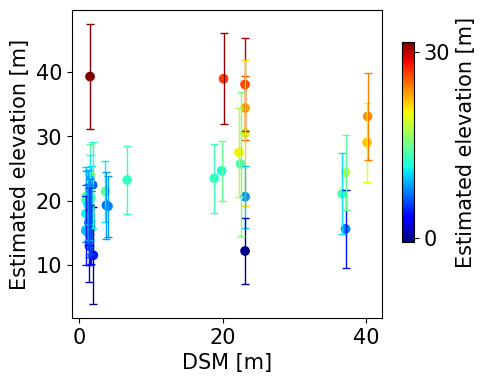

In [42]:
box = ['25.8719:25.8737','-80.1222:-80.1200']
plt.rcParams["font.size"] = "15"


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax=axs
lon, lat, demerr, dsm, dem, demerr_std = get_data_scatter(box=box, ps=True, offsetx=0, offsety=0)
im = ax.scatter(dsm, dem-demerr, c=-demerr, cmap='jet')
ax.set_xlabel('DSM [m]')
ax.set_ylabel('Estimated elevation [m]')

norm = matplotlib.colors.Normalize(vmin=min(dem-demerr), vmax=max(dem-demerr), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='jet')
time_color = np.array([(mapper.to_rgba(v)) for v in dem-demerr])

#loop over each data point to plot
for x, y, e, color in zip(dsm, dem-demerr,demerr_std, time_color):
    ax.errorbar(x, y, e, lw=1, capsize=3, color=color)



#ax.set_ylim(-30,50)
#ax.set_xlim(-30,50)

#cbar_ax1 = fig.add_axes([0.3, -0.1, 0.5, 0.03])
#fig.colorbar(im, cax=cbar_ax1,ticks=[0, 50], label='Estimated elevation [m]', orientation='horizontal')

cbar_ax1 = fig.add_axes([0.95, 0.3, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax1,ticks=[0, 30], label='Estimated elevation [m]', orientation='vertical')

correlation_matrix = np.corrcoef(dsm, -demerr)

#ax.set_title('R = {:.0f}%'.format(correlation_matrix[0,1]*100))



plt.savefig(out_dir + '/2_champlain_correlation_demErr_ps.png',bbox_inches='tight', dpi=300)

In [43]:
def get_data_ts(point, box, ps, yx=False):
    lats = [float(i) for i in box[0].split(':')]
    lons = [float(i) for i in box[1].split(':')]
    
    ts_file = project_dir + '/timeseries_SET_ERA5_demErr.h5'
    geo_file = project_dir + '/geo_corr/geometryRadar.h5'
    mask_file_t = project_dir + '/maskTempCoh.h5'
    mask_file_ps = project_dir + '/maskPS.h5'
    mask_file_w = project_dir + '/waterMask.h5'
    vel_file = project_dir + '/velocity.h5'
    
    velocity = readfile.read(vel_file, datasetName='velocity')[0]*1000
    
    stack_obj = timeseries(ts_file)
    stack_obj.open(print_msg=False)
    date_list = stack_obj.get_date_list()
    num_dates = len(date_list)
    
    mask_v = np.ones(velocity.shape)
    mask_v[np.abs(velocity) < 3] = 0
    


    
    mask_w = readfile.read(mask_file_w, datasetName='mask')[0]*mask_v
    mask_t = readfile.read(mask_file_t, datasetName='mask')[0]*mask_w
    mask_p = readfile.read(mask_file_ps, datasetName='mask')[0]*mask_w
    #
    
    if ps:
        mask = mask_p
    else:
        mask=mask_t

    latitude = readfile.read(geo_file, datasetName='latitude')[0]
    longitude = readfile.read(geo_file, datasetName='longitude')[0]
    
    mask[latitude<lats[0]] = 0
    mask[latitude>lats[1]] = 0
    mask[longitude<lons[0]] = 0
    mask[longitude>lons[1]] = 0

    
    lat = np.array(latitude[mask==1])
    lon = np.array(longitude[mask==1])
    
    ts = np.zeros([len(lat), num_dates])
    
    ts_p = np.zeros([point.shape[0], num_dates])
    ts_std = np.zeros([point.shape[0], num_dates])
    
    for i in range(point.shape[0]):
        if yx:
            dates_ts, ts_p[i,:], ts_std[i,:] = ut.read_timeseries_yx(point[i, 0], point[i, 1], ts_file, 
                                                      ref_y=refy, ref_x=refx,
                                                      win_size=2, unit='cm', print_msg=True)
        else:
            
            dates_ts, ts_p[i,:], ts_std[i,:] = ut.read_timeseries_lalo(point[i, 0], point[i, 1], ts_file, 
                                                      lookup_file=geo_file, ref_lat=reflat, ref_lon=reflon,
                                                      win_size=2, unit='cm', print_msg=True)
            
    
    #for i in range(len(lat)):
    #    dates_ts, ts[i, :] = ut.read_timeseries_lalo(lat[i], lon[i], ts_file, 
    #                                              lookup_file=geo_file, ref_lat=reflat, ref_lon=reflon,
    #                                              win_size=2, unit='mm', print_msg=True)[0:2]
    
    
    return lon, lat, dates_ts, ts, ts_p, ts_std

input y / x: 473 / 1568
input y / x: 469 / 1541


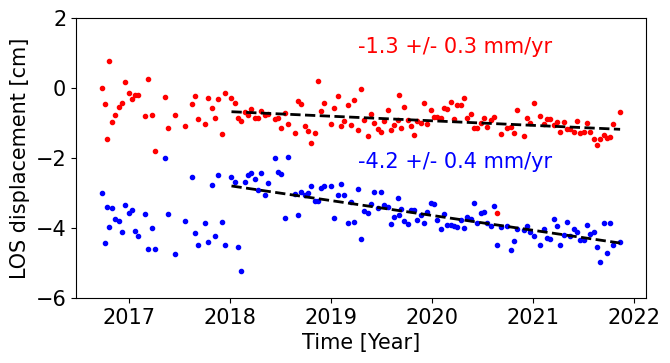

In [77]:
refy = 466
refx = 1546

reflat=25.8944
reflon=-80.1232

box = ['25.8936:25.8965','-80.1247:-80.1217'] 
#point = [25.8950, -80.1239]
#point = np.array([[25.8948, -80.1231],
#                  [25.8953, -80.1229]])

point = np.array([[473, 1568],
                  [469, 1541]])

lon, lat, dates_ts, ts, ts_p, ts_std = get_data_ts(point=point, box=box, ps=True, yx=True)

for ind in range(0, len(dates_ts)):
    if dates_ts[ind].year == 2018:
        break
        
plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(15, 10), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, right=0.4, top=0.98, bottom=0.7,
                        hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs1[0,0])
#for i in range(ts.shape[0]):
#    ax1.plot(dates_ts[4::], ts[i,4::]-ts[i,4], '--', color='gray')
    
#ax1.errorbar(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4], yerr=ts_std[0,4::], color='red', fmt='-',capsize=4, linewidth=2)
#ax1.errorbar(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] + 5, yerr=ts_std[1,4::], color='blue', fmt='-',capsize=4, linewidth=2)

ax1.plot(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4], '.', color='red',  linewidth=2)
ax1.plot(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] - 3, '.', color='blue', linewidth=2)

xx = [(x-dates_ts[4]).days for x in dates_ts[ind::]]
res1 = stats.linregress(xx, ts_p[0, ind::]-ts_p[0, 4])
ax1.plot(dates_ts[ind::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[70], 1.0, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='red')

res1 = stats.linregress(xx, ts_p[1, ind::]-ts_p[1, 4]-3)
ax1.plot(dates_ts[ind::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[70], -2.3, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='blue')

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.set_xlabel('Time [Year]')
ax1.set_ylabel('LOS displacement [cm]')
ax1.set_ylim(-6, 2)

plt.savefig(out_dir + '/ref_miami_ts_oceana.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

input y / x: 421 / 1531
input y / x: 420 / 1507


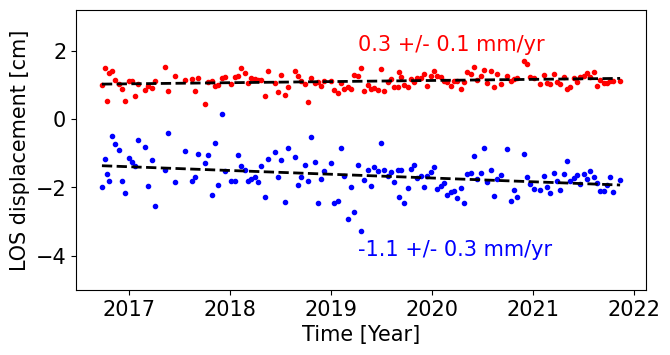

In [83]:
refy = 412
refx = 1509

reflat=25.8875
reflon=-80.1232

box = ['25.8871:25.8900','-80.1241:-80.1215']

#point = np.array([[25.8887, -80.1227],
#                  [25.8888, -80.1230]])


point = np.array([[421, 1531],
                  [420, 1507]])

lon, lat, dates_ts, ts, ts_p, ts_std = get_data_ts(point=point, box=box, ps=True, yx=True)


plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(15, 10), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, right=0.4, top=0.98, bottom=0.7,
                        hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs1[0,0])
#for i in range(ts.shape[0]):
#    ax1.plot(dates_ts[4::], ts[i,4::]-ts[i,4], '--', color='gray')
    
#ax1.errorbar(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4], yerr=ts_std[0,4::], color='red', fmt='-',capsize=4, linewidth=2)
#ax1.errorbar(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] + 5, yerr=ts_std[1,4::], color='blue', fmt='-',capsize=4, linewidth=2)

ax1.plot(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4] + 1, '.', color='red',  linewidth=2)
ax1.plot(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] - 2, '.', color='blue', linewidth=2)


xx = [(x-dates_ts[4]).days for x in dates_ts[4::]]
res1 = stats.linregress(xx, ts_p[0, 4::]-ts_p[0, 4] + 1)
ax1.plot(dates_ts[4::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[70], 2, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='red')

res1 = stats.linregress(xx, ts_p[1, 4::]-ts_p[1, 4] - 2)
ax1.plot(dates_ts[4::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[70], -4, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='blue')

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.set_xlabel('Time [Year]')
ax1.set_ylabel('LOS displacement [cm]')
ax1.set_ylim(-5, 3.2)

plt.savefig(out_dir + '/ref_miami_ts_regis.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

input y / x: 445 / 1231
input y / x: 443 / 1222


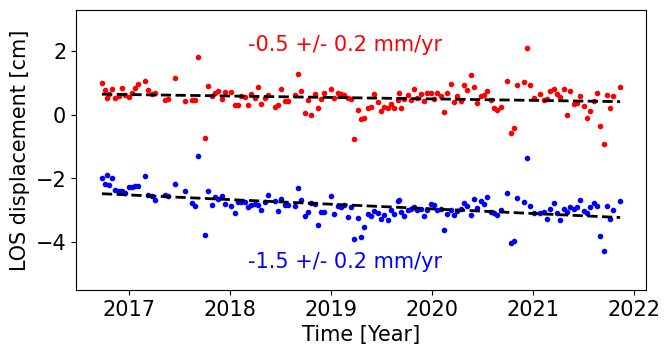

In [88]:
refy = 443
refx = 1247

reflat=25.8899
reflon=-80.1330

box = ['25.8895:25.8904','-80.1342:-80.1331']

#point = np.array([[25.8900, -80.1336],
#                  [25.8897, -80.1338]])

point = np.array([[445, 1231],
                  [443, 1222]])

lon, lat, dates_ts, ts, ts_p, ts_std = get_data_ts(point=point, box=box, ps=True, yx=True)


plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(15, 10), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, right=0.4, top=0.98, bottom=0.7,
                        hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs1[0,0])
#for i in range(ts.shape[0]):
#    ax1.plot(dates_ts[4::], ts[i,4::]-ts[i,4], '--', color='gray')
    
#ax1.errorbar(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4], yerr=ts_std[0,4::], color='red', fmt='-',capsize=4, linewidth=2)
#ax1.errorbar(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] + 5, yerr=ts_std[1,4::], color='blue', fmt='-',capsize=4, linewidth=2)

ax1.plot(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4] + 1, '.', color='red',  linewidth=2)
ax1.plot(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] - 2, '.', color='blue', linewidth=2)


xx = [(x-dates_ts[4]).days for x in dates_ts[4::]]
res1 = stats.linregress(xx, ts_p[0, 4::]-ts_p[0, 4] + 1)
ax1.plot(dates_ts[4::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[40], 2, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='red')

res1 = stats.linregress(xx, ts_p[1, 4::]-ts_p[1, 4] - 2)
ax1.plot(dates_ts[4::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[40], -4.8, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='blue')

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.set_xlabel('Time [Year]')
ax1.set_ylabel('LOS displacement [cm]')
ax1.set_ylim(-5.5, 3.3)

plt.savefig(out_dir + '/ref_miami_ts_kai.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

input y / x: 353 / 1494
input y / x: 354 / 1502
input y / x: 354 / 1528


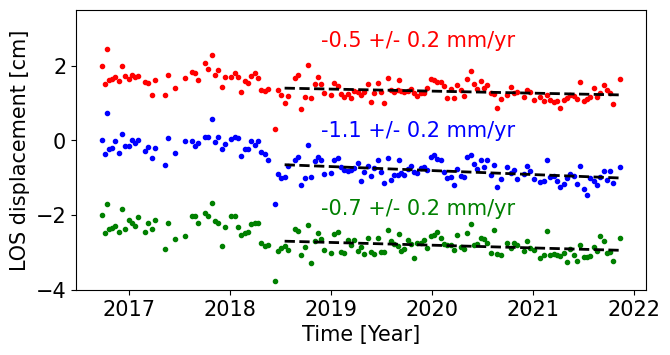

In [96]:
refy = 357
refx = 1486

reflat=25.8805
reflon=-80.1229

box = ['25.8796:25.8810','-80.1231:-80.1208']


point = np.array([[25.8801, -80.1226],
                  [25.8802, -80.1223],
                  [25.8804, -80.1214]])

point = np.array([[353, 1494],
                  [354, 1502],
                  [354, 1528]])

lon, lat, dates_ts, ts, ts_p, ts_std = get_data_ts(point=point, box=box, ps=True, yx=True)


plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(15, 10), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, right=0.4, top=0.98, bottom=0.7,
                        hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs1[0,0])
#for i in range(ts.shape[0]):
#    ax1.plot(dates_ts[4::], ts[i,4::]-ts[i,4], '--', color='gray')
    
#ax1.errorbar(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4], yerr=ts_std[0,4::], color='red', fmt='-',capsize=4, linewidth=2)
#ax1.errorbar(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] + 5, yerr=ts_std[1,4::], color='blue', fmt='-',capsize=4, linewidth=2)
ind = 50
ax1.plot(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4] + 2, '.', color='red',  linewidth=2)
ax1.plot(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] , '.', color='blue', linewidth=2)
ax1.plot(dates_ts[4::], ts_p[2, 4::]-ts_p[2, 4] - 2, '.', color='green', linewidth=2)


xx = [(x-dates_ts[ind]).days for x in dates_ts[ind::]]
res1 = stats.linregress(xx, ts_p[0, ind::]-ts_p[0, 4] + 2)
ax1.plot(dates_ts[ind::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[60], 2.5, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='red')

res1 = stats.linregress(xx, ts_p[1, ind::]-ts_p[1, 4])
ax1.plot(dates_ts[ind::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[60], 0.1, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='blue')

res1 = stats.linregress(xx, ts_p[2, ind::]-ts_p[2, 4] - 2)
ax1.plot(dates_ts[ind::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[60], -2, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='green')


years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.set_xlabel('Time [Year]')
ax1.set_ylabel('LOS displacement [cm]')
ax1.set_ylim(-4, 3.5)

plt.savefig(out_dir + '/ref_miami_ts_residence.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

input y / x: 377 / 1526
input y / x: 373 / 1518


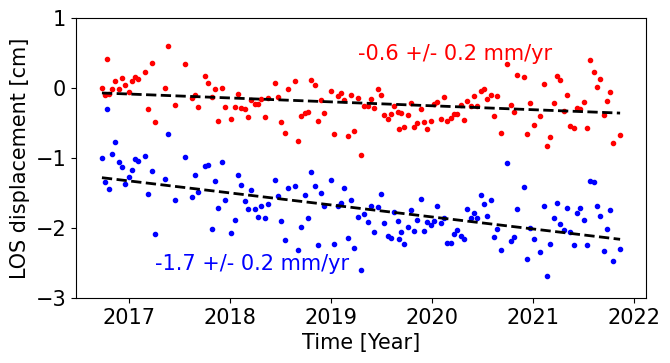

In [100]:
refy = 381
refx = 1498

reflat = 25.8835
reflon = -80.1231

box = ['25.8822:25.8847','-80.1236:-80.1210']

point = np.array([[25.8832, -80.1219],
                  [25.8827, -80.1219]])

point = np.array([[377, 1526],
                  [373, 1518]])

lon, lat, dates_ts, ts, ts_p, ts_std = get_data_ts(point=point, box=box, ps=True, yx=True)


plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(15, 10), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, right=0.4, top=0.98, bottom=0.7,
                        hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs1[0,0])
#for i in range(ts.shape[0]):
#    ax1.plot(dates_ts[4::], ts[i,4::]-ts[i,4], '--', color='gray')
    
#ax1.errorbar(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4], yerr=ts_std[0,4::], color='red', fmt='-',capsize=4, linewidth=2)
#ax1.errorbar(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] + 5, yerr=ts_std[1,4::], color='blue', fmt='-',capsize=4, linewidth=2)

ax1.plot(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4] , '.', color='red',  linewidth=2)
ax1.plot(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] -1, '.', color='blue', linewidth=2)


xx = [(x-dates_ts[4]).days for x in dates_ts[4::]]
res1 = stats.linregress(xx, ts_p[0, 4::]-ts_p[0, 4])
ax1.plot(dates_ts[4::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[70], 0.4, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='red')

res1 = stats.linregress(xx, ts_p[1, 4::]-ts_p[1, 4]-1)
ax1.plot(dates_ts[4::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[20], -2.6, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='blue')

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.set_xlabel('Time [Year]')
ax1.set_ylabel('LOS displacement [cm]')
ax1.set_ylim(-3, 1)

plt.savefig(out_dir + '/ref_miami_ts_grandbeach.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

input y / x: 294 / 1485
input y / x: 295 / 1496


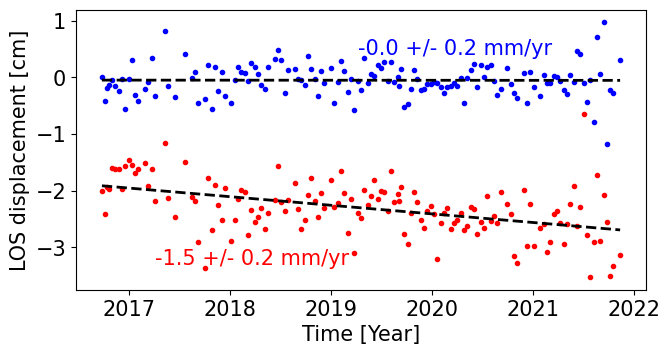

In [108]:
refy = 295
refx = 1466
box = ['25.8719:25.8737','-80.1222:-80.1200']

point = np.array([[294, 1485],
                  [295, 1496]])

lon, lat, dates_ts, ts, ts_p, ts_std = get_data_ts(point=point, box=box, ps=True, yx=True)


plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(15, 10), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, right=0.4, top=0.98, bottom=0.7,
                        hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs1[0,0])
#for i in range(ts.shape[0]):
#    ax1.plot(dates_ts[4::], ts[i,4::]-ts[i,4], '--', color='gray')
    
#ax1.errorbar(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4], yerr=ts_std[0,4::], color='red', fmt='-',capsize=4, linewidth=2)
#ax1.errorbar(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] + 5, yerr=ts_std[1,4::], color='blue', fmt='-',capsize=4, linewidth=2)

ax1.plot(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4] - 2, '.', color='red',  linewidth=2)
ax1.plot(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] , '.', color='blue', linewidth=2)


xx = [(x-dates_ts[4]).days for x in dates_ts[4::]]
res1 = stats.linregress(xx, ts_p[0, 4::]-ts_p[0, 4] - 2)
ax1.plot(dates_ts[4::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[20], -3.3, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='red')

res1 = stats.linregress(xx, ts_p[1, 4::]-ts_p[1, 4])
ax1.plot(dates_ts[4::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
ax1.text(dates_ts[70], 0.4, '{:.1f} +/- {:.1f} mm/yr'.format(res1.slope*3652.5, res1.stderr*3652.5), color='blue')

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.set_xlabel('Time [Year]')
ax1.set_ylabel('LOS displacement [cm]')
#ax1.set_ylim(-3, 1)

plt.savefig(out_dir + '/ref_miami_ts_champlain.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()